In [ ]:
!pip install streamlit
!pip install tensorflow
!pip install keras_applications
!pip install tensorflow-addons

In [ ]:
pip install --upgrade tensorflow

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,GlobalAveragePooling2D,Input
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import callbacks,optimizers
from PIL import Image
import numpy as np
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Dog/

/content/drive/MyDrive/Dog


In [ ]:
#!unzip Train.zip
#!unzip Test.zip

In [ ]:
for i in os.listdir("Train"):
  print(i,len(os.listdir("Train/"+i)))

In [ ]:
for i in os.listdir("Test"):
  print(i,len(os.listdir("Test/"+i)))

In [ ]:
import random

train_dir = "Train"
class_names = os.listdir(train_dir)

# Count the total number of images and classes in the directory
total_images = sum([len(files) for root, dirs, files in os.walk(train_dir)])
total_classes = len(class_names)
avg_images_per_class = total_images / total_classes

print(f"Total number of images: {total_images}")
print(f"Total number of classes: {total_classes}")
print(f"Average training per class: {avg_images_per_class:.2f}")

# Randomly pick 9 images from the directory
image_paths = []
for i in range(9):
    class_name = random.choice(class_names)
    class_path = os.path.join(train_dir, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    image_paths.append(image_path)

# Display the randomly picked images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(7, 5))
for i, ax in enumerate(axes.flat):
    # Load and resize the image
    img = Image.open(image_paths[i])
    img = img.resize((224, 224))
    # Display the image
    ax.imshow(img)
    class_name = os.path.basename(os.path.dirname(image_paths[i]))
    class_name = class_name[:20] + "..." if len(class_name) > 20 else class_name
    ax.set_title(class_name)
    ax.axis("off")
plt.show()

In [ ]:
def img_Data(dir_path,target_size,batch,class_lst,preporcssing,):
  if preporcssing:
    gen_object = ImageDataGenerator(preprocessing_function=preporcssing)
  else:
    gen_object = ImageDataGenerator()

  return(gen_object.flow_from_directory(dir_path,
                                          target_size=target_size,
                                          batch_size=batch,
                                          class_mode='sparse',
                                          classes=class_lst,
                                          shuffle=True))

# โค้ดนี้เป็นฟังก์ชันที่ใช้สำหรับสร้าง Iterator ของข้อมูลรูปภาพจากไดเรกทอรี (directory) ที่มีไฟล์รูปภาพอยู่ภายใน โดยใช้งานคลาส ImageDataGenerator ของ Keras โดยรับพารามิเตอร์ดังนี้
# dir_path: ตำแหน่งของไดเรกทอรีที่มีไฟล์รูปภาพอยู่
# target_size: ขนาดของรูปภาพที่ต้องการให้มีหลังจากการ resize
# batch: จำนวนรูปภาพที่จะส่งออกมาในแต่ละครั้ง
# class_lst: ชื่อคลาสของไฟล์รูปภาพ
# preporcssing: ฟังก์ชันการประมวลผลรูปภาพก่อนส่งเข้าโมเดล (ใช้เช่นเดียวกับพารามิเตอร์ preprocessing_function ของ ImageDataGenerator)
# โดย Iterator ของข้อมูลที่สร้างขึ้นจะมีค่าเป็น tuple โดยมี elements 2 ตัว คือ ภาพและ class ที่เรียกว่า sparse class เพื่อเก็บข้อมูลชื่อคลาสของแต่ละรูปภาพในรูปแบบของเลขจำนวนเต็ม

In [ ]:
# preprocess_input: ฟังก์ชันการประมวลผลรูปภาพก่อนส่งเข้าโมเดล (ใช้เช่นเดียวกับพารามิเตอร์ preprocessing_function ของ ImageDataGenerator)
# Iterator ของข้อมูลที่สร้างขึ้นจะมีค่าเป็น tuple โดยมี elements 2 ตัว คือ ภาพและ class ที่เรียกว่า sparse class เพื่อเก็บข้อมูลชื่อคลาสของแต่ละรูปภาพในรูปแบบของเลขจำนวนเต็ม สำหรับ train_data_gen จะใช้ไฟล์รูปภาพจาก Train และ valid_data_gen จะใช้ไฟล์รูปภาพจาก Test
train_data_gen = img_Data("Train",(224,224),500,os.listdir("Train"),preprocess_input)
valid_data_gen = img_Data("Test",(224,224),500,os.listdir("Test"),preprocess_input)

Found 12000 images belonging to 120 classes.
Found 2402 images belonging to 120 classes.


In [ ]:
# MobileNetV2 เป็นโมเดล Neural Network ที่ถูกออกแบบมาสำหรับการประมวลผลภาพบนอุปกรณ์พกพา 
# ถูกพัฒนาโดยกลุ่มวิจัยของ Google โดยใช้โครงข่าย Convolutional Neural Network (CNN) แบบ Depthwise Separable Convolution ที่ช่วยลดจำนวนพารามิเตอร์และเวลาในการทำงาน 
# ได้รับความนิยมในการใช้งานในงาน Computer Vision ต่าง ๆ เช่น Object Detection, Image Classification และ Segmentation เป็นต้น 
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# weight ของโมเดลจะไม่ถูกอัปเดตในรอบการฝึกต่อไป
base_model.trainable = False

In [ ]:
# เพิ่ม layer แบบ fully connected layer ที่มี 1024 neurons และใช้ฟังก์ชัน activation แบบ relu
# เพิ่ม layer แบบ fully connected layer ที่มี 120 neurons และใช้ฟังก์ชัน activation แบบ softmax เพื่อให้สามารถจำแนกภาพสัตว์ต่างๆ ได้ 120 ชนิดตาม dataset ที่ใช้
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dense(120,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 120)               123000    
                                                                 
Total params: 3,692,728
Trainable params: 1,434,744
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# สร้าง callbacks สองตัวเพื่อใช้ในการจัดการกับการทำงานของโมเดล Keras ในระหว่างการฝึกฝน (training) ดังนี้
# callbacks.EarlyStopping: เป็น callback ที่ใช้สำหรับหยุดการฝึกฝน (training) ก่อนจนกว่าค่า validation loss จะเริ่มเพิ่มขึ้น โดยมีพารามิเตอร์ดังนี้
# monitor: ชื่อ metric ที่ต้องการตรวจสอบเพื่อใช้เป็นตัวบอกว่าจะหยุดการฝึกฝนหรือไม่ ในที่นี้คือ 'val_loss' หมายถึง validation loss กำหนดค่า min เมื่อ val_loss สูงขึ้นจะหยุด Train
# patience: จำนวนรอบที่ต้องผ่านไปก่อนที่จะหยุดการฝึกฝน ในที่นี้คือ 5 รอบ
# callbacks.ModelCheckpoint: เป็น callback ที่ใช้สำหรับบันทึกโมเดลที่มีค่า loss ที่ดีที่สุดในแต่ละรอบการฝึกฝน 

elst = callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')
save_ck = callbacks.ModelCheckpoint('.mdl_wt2.hdf5',save_best_only=True,monitor='val_loss',mode ='min')

In [ ]:
#train_data_gen โดยใช้ batch_size เท่ากับ 500 และใช้ข้อมูล validation จาก valid_data_gen ในการตรวจสอบความแม่นยำของโมเดล
#การฝึกโมเดลจะมีการใช้ callbacks ซึ่งเป็นฟังก์ชันเพื่อให้โมเดลหยุดการฝึกได้ทันทีเมื่อเงื่อนไขที่กำหนดไว้เป็นจริง ในที่นี้ใช้ EarlyStopping เพื่อหยุดการฝึกเมื่อค่าความสูญเสียในชุด validation ไม่ลดลงเป็นเวลา 5 รอบ และใช้ ModelCheckpoint เพื่อบันทึกโมเดลที่มีค่าความสูญเสียต่ำที่สุดในชุด validation
model.fit(train_data_gen,batch_size=500,validation_data=valid_data_gen,callbacks=[elst,save_ck],epochs=10)

Epoch 1/10
24/24 [==============================] - 113s 4s/step - loss: 1.8038 - accuracy: 0.5897 - val_loss: 0.8115 - val_accuracy: 0.7569
Epoch 2/10
24/24 [==============================] - 90s 4s/step - loss: 0.5357 - accuracy: 0.8303 - val_loss: 0.6790 - val_accuracy: 0.7906
Epoch 3/10
24/24 [==============================] - 88s 4s/step - loss: 0.3422 - accuracy: 0.8943 - val_loss: 0.6555 - val_accuracy: 0.7964
Epoch 4/10
24/24 [==============================] - 95s 4s/step - loss: 0.2379 - accuracy: 0.9305 - val_loss: 0.6531 - val_accuracy: 0.8047
Epoch 5/10
24/24 [==============================] - 90s 4s/step - loss: 0.1750 - accuracy: 0.9557 - val_loss: 0.6331 - val_accuracy: 0.8068
Epoch 6/10
24/24 [==============================] - 86s 4s/step - loss: 0.1335 - accuracy: 0.9695 - val_loss: 0.6417 - val_accuracy: 0.8156
Epoch 7/10
24/24 [==============================] - 94s 4s/step - loss: 0.0989 - accuracy: 0.9833 - val_loss: 0.6465 - val_accuracy: 0.8102
Epoch 8/10
24/24 [=

In [ ]:
# loss: 0.0478 คือค่าเฉลี่ยของความสูญเสียในการเทรนโมเดลในชุดข้อมูลสอน
# accuracy: 0.9962 คือค่าเฉลี่ยความแม่นยำในการเทรนโมเดลในชุดข้อมูลสอน
# val_loss: 0.6484 คือค่าเฉลี่ยของความสูญเสียในการตรวจสอบโมเดลในชุดข้อมูล validation set
# val_accuracy: 0.8147 คือค่าเฉลี่ยความแม่นยำในการตรวจสอบโมเดลในชุดข้อมูล validation set

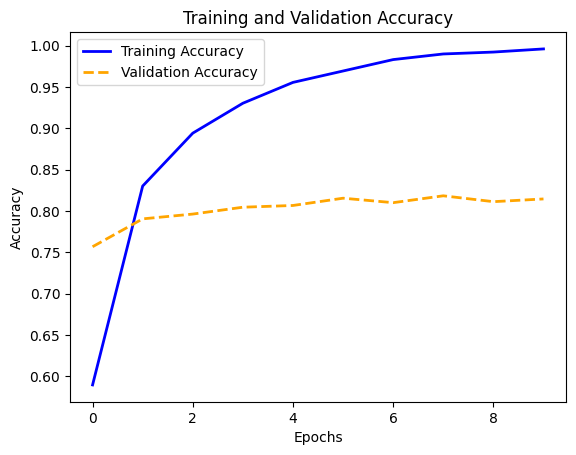

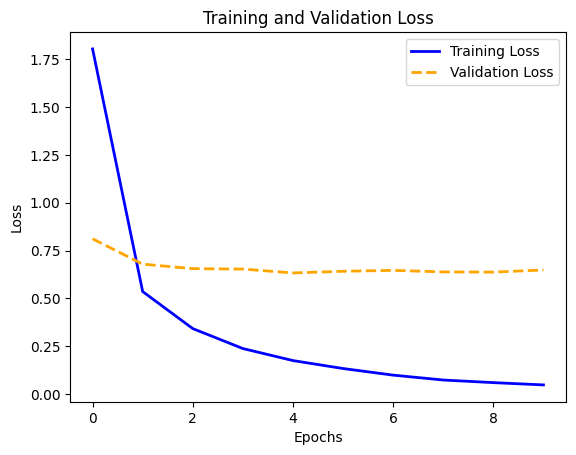

In [ ]:
# สร้าง graph ที่จะแสดงค่า accuracy ของ training และ validation
plt.plot(model.history.history['accuracy'], label='training accuracy')
plt.plot(model.history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# สร้าง graph ที่จะแสดงค่า loss ของ training และ validation
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()